# Question Answers Generations Model

In [238]:
# Dependencies
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dense, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

In [239]:
# get the data
df = pl.read_csv('dataset/train_data_cleaned.csv')
df.shape, df.to_pandas().info(), type(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0                 86821 non-null  int64 
 1   title         86821 non-null  object
 2   context       86821 non-null  object
 3   questions     86821 non-null  object
 4   final_answer  86821 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


((86821, 5), None, polars.internals.dataframe.frame.DataFrame)

In [240]:
df.sample(20)

,title,context,questions,final_answer
i64,str,str,str,str
80529,"""Detroit""","""Detroit is the...","""How big is the...","""5,700,000"""
129982,"""Kathmandu""","""The National L...","""Who did the Ka...","""Kaiser Shamshe..."
91953,"""United_States_...","""In September 2...","""What were Wesl...","""leadership and..."
90032,"""Karl_Popper""","""According to t...","""What concept d...","""metalanguage"""
47750,"""Ashkenazi_Jews...","""In the Midrash...","""What is the na...","""Rabbi Berechia..."
120003,"""Indigenous_peo...","""Over the cours...","""How were new s...","""artificial sel..."
99457,"""Idealism""","""Plato's theory...","""Who regarded P...","""Simone Klein"""
60197,"""Marvel_Comics""","""In late 1994, ...","""When did Marve...","""1994"""
56700,"""Napoleon""","""He was moved t...","""After his move...","""Constantinople..."


In [241]:
# null check
df.null_count()

,title,context,questions,final_answer
u32,u32,u32,u32,u32
0,0,0,0,0


In [242]:
#drop nulls
df.drop_nulls()

,title,context,questions,final_answer
i64,str,str,str,str
0,"""Beyoncé""","""Beyoncé Gisell...","""When did Beyon...","""in the late 19..."
1,"""Beyoncé""","""Beyoncé Gisell...","""What areas did...","""singing and da..."
2,"""Beyoncé""","""Beyoncé Gisell...","""When did Beyon...","""2003"""
3,"""Beyoncé""","""Beyoncé Gisell...","""In what city a...","""Houston, Texas..."
4,"""Beyoncé""","""Beyoncé Gisell...","""In which decad...","""late 1990s"""
5,"""Beyoncé""","""Beyoncé Gisell...","""In what R&B gr...","""Destiny's Chil..."
6,"""Beyoncé""","""Beyoncé Gisell...","""What album mad...","""Dangerously in..."
7,"""Beyoncé""","""Beyoncé Gisell...","""Who managed th...","""Mathew Knowles..."
8,"""Beyoncé""","""Beyoncé Gisell...","""When did Beyon...","""late 1990s"""


# Here we will add a new columns to data which can be a switch wheather we want question and ans from model or just answers

In [243]:
modes = {
    'find_answers':0,
    'geneate_questions': 1
    }


In [244]:
df = df.with_columns([
    (pl.col("context").apply(lambda x: len(str(x).split(' '))).alias("context_len")),
    (pl.col("questions").apply(lambda x: len(str(x).split(' '))).alias("question_len")),
    (pl.col("final_answer").apply(lambda x: len(str(x).split(' '))).alias("answer_len"))])

In [245]:
df

,title,context,questions,final_answer,context_len,question_len,answer_len
i64,str,str,str,str,i64,i64,i64
0,"""Beyoncé""","""Beyoncé Gisell...","""When did Beyon...","""in the late 19...",109,6,4
1,"""Beyoncé""","""Beyoncé Gisell...","""What areas did...","""singing and da...",109,11,3
2,"""Beyoncé""","""Beyoncé Gisell...","""When did Beyon...","""2003""",109,11,1
3,"""Beyoncé""","""Beyoncé Gisell...","""In what city a...","""Houston, Texas...",109,11,2
4,"""Beyoncé""","""Beyoncé Gisell...","""In which decad...","""late 1990s""",109,7,2
5,"""Beyoncé""","""Beyoncé Gisell...","""In what R&B gr...","""Destiny's Chil...",109,9,2
6,"""Beyoncé""","""Beyoncé Gisell...","""What album mad...","""Dangerously in...",109,8,3
7,"""Beyoncé""","""Beyoncé Gisell...","""Who managed th...","""Mathew Knowles...",109,6,2
8,"""Beyoncé""","""Beyoncé Gisell...","""When did Beyon...","""late 1990s""",109,6,2


# Dataset Analysis

In [261]:
#plotting a verticle axis for 95% mark
def dist_info(x, r:tuple = (90,100), bins:int = 100, title = 'old', xlim:list = None, ylim:list = None):
    
    '''
    this function plot distribution of series with axis lines with given range.
    
    x : series  = series of numbers
    r : tuple   =  tuple with low and high values to plot
    title : str =  title of the plot
    xlim : list = low and high limit to limit the plot
    ylim : list = similar to xlim
    '''
    
    print('Percent  ::   words  \n')
    plt.figure(figsize = (25,5))
    sns.histplot(x = x, bins = bins)

    for percent in range(r[0], r[1]+1):
        perc_x = np.percentile(x, percent)
        print(f'{percent:6}%  ::   {perc_x} words') 
        plt.axvline(x = perc_x, color = 'red')
        plt.text(x = perc_x, y = 2500+np.random.randint(100, 400), s = f'{percent}%')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    if title =='old':
        plt.title(f'Length Distribution of {x.name}')
    else:
        plt.title(str(title))
    plt.show()


## 1. Context

Percent  ::   words  

    95%  ::   213.0 words
    96%  ::   222.0 words
    97%  ::   234.0 words
    98%  ::   252.0 words
    99%  ::   283.0 words
   100%  ::   653.0 words


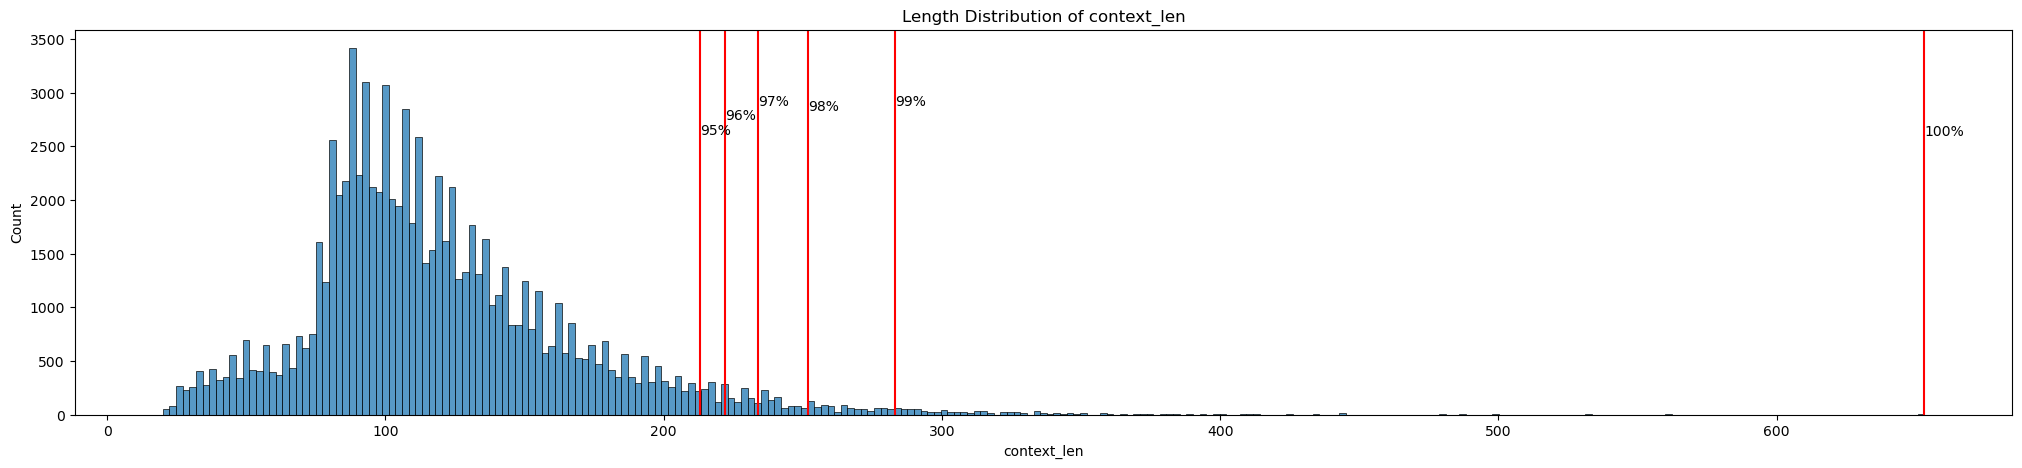

In [247]:
dist_info(df['context_len'], (95,100))


In Order to Cover 100 percent of the data we need to create input length of 653 words which is too much. while just 213 words cover 95 % of the data. 
so lets take 500 words as a context input it will cover99% data.

In [248]:
context_input_len = 500 + 2 # for <SOS> AND <EOS>

## 2. Questions

In [249]:
df['question_len'].max()

25601

In [250]:
dist_info(x = df['question_len'], r = (95,100), xlim=[0,40])

Percent  ::   words  

    95%  ::   17.0 words
    96%  ::   17.0 words
    97%  ::   18.0 words
    98%  ::   19.0 words
    99%  ::   21.0 words
   100%  ::   25601.0 words


ValueError: Image size of 1240181x468 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2500x500 with 1 Axes>

Similar to context , for input for questions we would go with 50 words , it covers 99% data 

In [251]:
question_inputs_len = 50 + 2 # for <SOS> AND <EOS>

## 3. Answers

Percent  ::   words  

    95%  ::   10.0 words
    96%  ::   11.0 words
    97%  ::   13.0 words
    98%  ::   15.0 words
    99%  ::   18.0 words
   100%  ::   43.0 words


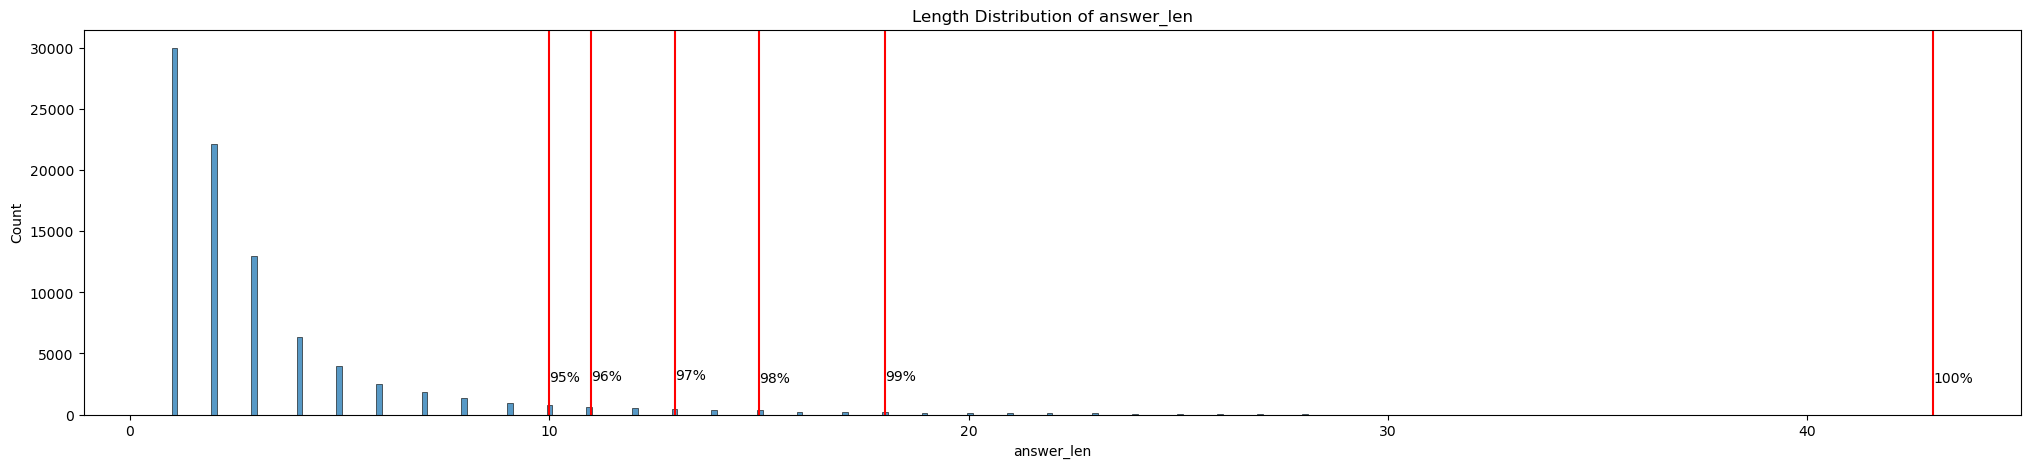

In [252]:
dist_info(df['answer_len'], (95,100))


Similar to context , for input for answers we would go with 50 words , it covers 100% data 

In [253]:
answer_inputs_len = 50 + 2 # for <SOS> AND <EOS>

# Preprocessing TEXT

In [254]:


import re
import json

with open('contractions.json') as f:
   contractions_dict = json.load(f)


In [255]:
# very necessary function you can't tell differece between "’" and "'", I don't even have that symbol in my keyboard
def text_cleaning_apos(text):
    text = str(text)
    text = text.lower()
    text = re.sub("’", "'", text) # removing punctuation
    return text

In [256]:
# FUNCTIONS TO EXPAND CONTRACTIONS
def cont_to_exp(x):
    x = str(x).lower()
    xsplited = x.split(' ')
    exp_sentence = []
    for s in x.split():
        if s in contractions_dict.keys():
            
            s = contractions_dict.get(s)
        exp_sentence.append(s)
        
    x = ' '.join(exp_sentence)
    return x


In [257]:

def text_cleaning(text):
    text = str(text)
    text = text.lower()
    # text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    # remove special characters from text column
    text = re.sub('[#,@,&]', '',text)
    # Remove digits
    # text = re.sub('\d*','', text)
    # remove "'s"
    text = re.sub("'s",'', text)
    text = re.sub("?",' ?', text)
    text = re.sub(".",' .', text)
    text = re.sub("!",' !', text)

    #Remove www
    # text = re.sub('w{3}','', text)
    # remove urls
    # text = re.sub("http\S+", "", text)
    # remove multiple spaces with single space
    # text = re.sub('\s+', ' ', text)
    #remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text


In [258]:
# func 1
df = df.with_columns([
    (pl.col("context").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("questions").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("final_answer").apply(lambda x: text_cleaning_apos(x)))

])

In [259]:
# func 2
df = df.with_columns([
    (pl.col("context").apply(lambda x: cont_to_exp(x))),
    (pl.col("questions").apply(lambda x: cont_to_exp(x))),
    (pl.col("final_answer").apply(lambda x: cont_to_exp(x)))

])

In [260]:
# func 3
df = df.with_columns([
    (pl.col("context").apply(lambda x: text_cleaning(x))),
    (pl.col("questions").apply(lambda x: text_cleaning(x))),
    (pl.col("final_answer").apply(lambda x: text_cleaning(x)))

])

ComputeError: error: nothing to repeat at position 0

In [ ]:
df

In [ ]:
df.filter(df['question_len'] < 5)